# Searching in a transformed space

In the previous part of the tutorial we set up boundaries and created a method to sample from within those boundaries.
When doing this, we found it useful to replace some parameter values with their logarithm.
In this part of the tutorial we extend this log-transformation approach to the optimisation routine, so that we search in a (partly) log-transformed space.

## Why transform the search space?

Before performing parameter estimation it _can_ be a good idea to perform some kind of transformations on the search space.
For example, some optimisation methods don't perform well on spaces where the error measure varies very rapidly in one direction, but slowly in another.
In these cases it might help to rescale the parameters, e.g. so that they are all restricted to the interval $[0, 1]$.


For the "a-type" parameters in the model used in this tutorial, [Beattie et al.](https://doi.org/10.1113/JP275733) found the prior expectation was for them to vary over many orders of magnitude.
As a result, it seemed sensible to use a log-transformation on these parameters when searching, which led to notably improved results.
Further experimental confirmation of this result was provided in the supplemental results to ["Four Ways to Fit an Ion Channel Model"](https://doi.org/10.1016/j.bpj.2019.08.001), section S2.4.2.

While there is no catch-all strategy that we know of, it may be a good idea to try several transformations when dealing with a difficult parameter estimation problem.
The following section will show how.

## Implementing transformations with wrappers

In this section, we'll set up a synthetic data problem with a forward model and boundaries, and then use _wrappers_ around both to perform the log transformations.

First, we create a class that can transform points from the "model space" to the "search space" and vice versa.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import myokit
import pints

In [3]:
class LogTransform(object):
    """
    Performs forward and backward transformations on the 
    alpha-parameters used in the Beattie et al. model.    
    """
    
    def to_search(self, x):
        """Transforms from model to search space."""
        q = np.copy(x)
        q[0] = np.log(x[0])
        q[2] = np.log(x[2])
        q[4] = np.log(x[4])
        q[6] = np.log(x[6])
        return q

    def to_model(self, q):
        """Transforms from search to model space."""
        x = np.copy(q)
        x[0] = np.exp(q[0])
        x[2] = np.exp(q[2])
        x[4] = np.exp(q[4])
        x[6] = np.exp(q[6])
        return x        

Next, we define a wrapper around the forward model class and around the boundaries class.

In [4]:
class TransformedForwardModel(pints.ForwardModel):
    """
    Wraps around a ``pints.ForwardModel`` and applies parameter 
    transformations.
    """
    
    def __init__(self, model, transform):
        self._model = model
        self._transform = transform
    
    def n_parameters(self):
        return self._model.n_parameters()
    
    def simulate(self, search_parameters, times):
        model_parameters = self._transform.to_model(search_parameters)
        return self._model.simulate(model_parameters, times)

    
class TransformedBoundaries(pints.Boundaries):
    """
    Wraps around a ``pints.Boundaries`` object and applies parameter
    transformations.
    """
    def __init__(self, boundaries, transform):
        self._boundaries = boundaries
        self._transform = transform
    
    def check(self, search_parameters):
        model_parameters = self._transform.to_model(search_parameters)
        return self._boundaries.check(model_parameters)
    
    def n_parameters(self):
        return self._boundaries.n_parameters()
    
    def sample(self, n):
        model_parameters = self._boundaries.sample(n)
        search_parameters = np.zeros(model_parameters.shape)
        for i, p in enumerate(model_parameters):
            search_parameters[i] = self._transform.to_search(p)
        return search_parameters


Next, we set up an optimisation problem:

In [5]:
# Load a protocol and create a foward model instance
from library import ModelHHSolver as Model
protocol = myokit.load_protocol('resources/simplified-staircase.mmt')
model = Model(protocol)

# Define a parameter vector
parameters = np.array([3e-4, 0.07, 3e-5, 0.05, 0.09, 9e-2, 5e-3, 0.03, 0.2])

# Set up a synthetic data problem and error
times = np.arange(0, 15400, 0.1)
values = model.simulate(parameters, times)
values += np.random.normal(0, 0.025, times.shape)
problem = pints.SingleOutputProblem(model, times, values)
error = pints.MeanSquaredError(problem)

# Create boundaries and take a random sample as initial starting point
from library import Boundaries
boundaries = Boundaries()

# Make a random guess for the parameters
x0 = boundaries.sample(1)[0]

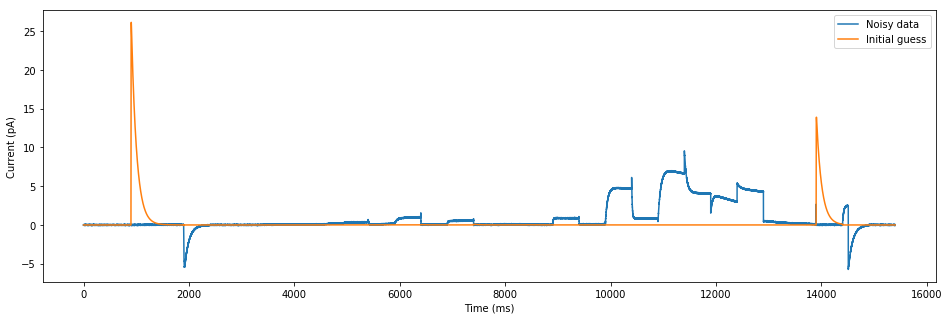

In [6]:
# Visualise the data and starting point
plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(times, values, label='Noisy data')
plt.plot(times, problem.evaluate(x0), label='Initial guess')
plt.legend()
plt.show()

To check if it's working, we can run an evaluation with x0 and its transformed counterpart:

In [7]:
# Create the transformation object
transform = LogTransform()

# Create a transformed model and transformed boundaries
transformed_model = TransformedForwardModel(model, transform)
transformed_boundaries = TransformedBoundaries(boundaries, transform)

# Set up a problem with the transformed model
transformed_problem = pints.SingleOutputProblem(transformed_model, times, values)
transformed_error = pints.MeanSquaredError(transformed_problem)

# Create a transformed starting point
q0 = transform.to_search(x0)

print('Untransformed:')
print(x0)
print('Transformed:')
print(q0)


Untransformed:
[3.21606126e-03 1.16571839e-01 5.39854319e-01 3.70106395e-03
 6.50846190e-03 1.09590375e-02 1.17145562e-05 5.78290554e-02
 9.35638139e-01]
Transformed:
[-5.73959788e+00  1.16571839e-01 -6.16455956e-01  3.70106395e-03
 -5.03465212e+00  1.09590375e-02 -1.13546784e+01  5.78290554e-02
  9.35638139e-01]


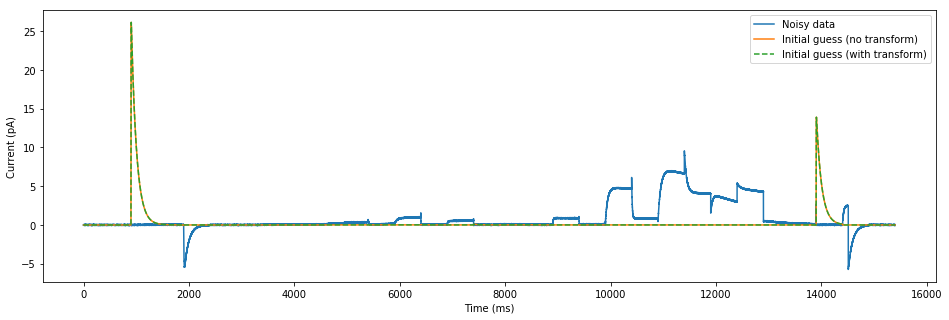

In [8]:
plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(times, values, label='Noisy data')
plt.plot(times, problem.evaluate(x0), 
         label='Initial guess (no transform)')
plt.plot(times, transformed_problem.evaluate(q0), '--',
         label='Initial guess (with transform)')
plt.legend()
plt.show()

Now lets run an optimisation, without using log transforms:

In [9]:
opt = pints.OptimisationController(error, x0, boundaries=boundaries)
opt.set_parallel(True)
x1, f1 = opt.run()

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 4 worker processes.
Population size: 10
Iter. Eval. Best      Time m:s
0     10     5.989626   0:00.3
1     19     4.724501   0:00.4
2     26     4.168046   0:00.5
3     30     4.168046   0:00.6
20    157    4.140194   0:02.8
40    300    4.140194   0:05.3
60    429    4.138454   0:07.6
80    565    4.138454   0:10.3
100   705    4.138454   0:13.2
120   833    4.13595    0:15.5
140   985    4.135356   0:17.9
160   1119   4.135356   0:20.3
180   1260   4.135306   0:23.2
200   1417   4.128607   0:25.8
220   1575   4.093576   0:28.4
240   1703   4.06938    0:30.6
260   1839   4.068263   0:32.9
280   1954   4.067509   0:35.0
300   2092   4.067485   0:38.1
320   2219   4.067485   0:40.6
340   2340   4.067484   0:43.1
360   2465   4.067481   0:45.2
380   2602   4.06747    0:47.6
400   2734   4.067434   0:49.9
420   2895   4.0674     0:52.5
440   3038   4.067399   0:54.9
460   3175

5120  40281  0.0631    11:35.5
5140  40481  0.0627    11:38.7
5160  40681  0.0622    11:41.8
5180  40881  0.0585    11:45.0
5200  41081  0.0455    11:48.2
5220  41281  0.024502  11:51.3
5240  41481  0.00936   11:54.4
5260  41681  0.00346   11:57.5
5280  41881  0.00103   12:00.8
5300  42081  0.000669  12:04.0
5320  42281  0.000623  12:07.2
5340  42481  0.000622  12:10.4
5360  42681  0.000622  12:13.5
5380  42881  0.000622  12:16.6
5400  43081  0.000622  12:19.6
5420  43281  0.000622  12:22.8
5440  43481  0.000622  12:25.9
5460  43681  0.000622  12:29.0
5480  43881  0.000622  12:32.2
5500  44081  0.000622  12:35.5
5520  44281  0.000622  12:38.7
5540  44481  0.000622  12:41.8
5560  44681  0.000622  12:44.9
5580  44881  0.000622  12:48.1
5588  44951  0.000622  12:49.2
Halting: No significant change for 200 iterations.


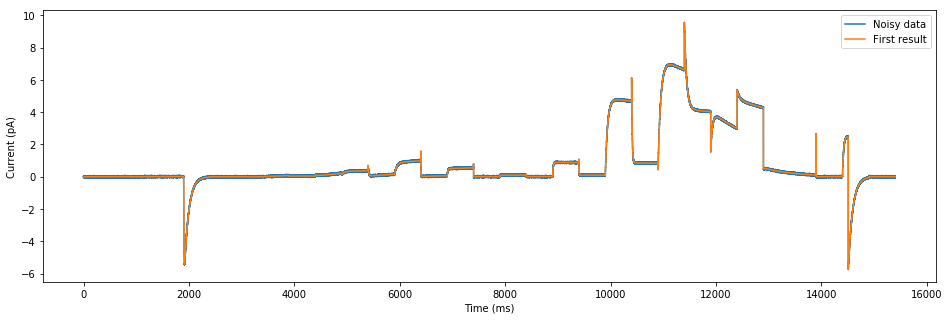

In [10]:
plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(times, values, label='Noisy data')
plt.plot(times, problem.evaluate(x1), label='First result')
plt.legend()
plt.show()

And repeat, but this time using log-transforms on the a-type parameters:

In [11]:
# Run the optimisation
opt = pints.OptimisationController(
    transformed_error, q0, boundaries=transformed_boundaries)
opt.set_parallel(True)
q2, f2 = opt.run()

# De-transform the result
x2 = transform.to_model(q2)

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 4 worker processes.
Population size: 10
Iter. Eval. Best      Time m:s
0     10     6.56009    0:00.2
1     20     6.149878   0:00.4
2     30     5.889101   0:00.6
3     40     5.666281   0:00.7
20    170    4.06881    0:02.8
40    311    4.06792    0:05.3
60    439    4.067147   0:07.4
80    559    4.049359   0:09.6
100   697    4.048188   0:11.9
120   823    4.03448    0:14.1
140   942    3.934686   0:16.2
160   1039   3.859072   0:17.9


/usr/local/lib/python3.7/site-packages/cma/evolution_strategy.py:3399: RuntimeWarning: invalid value encountered in double_scalars
  es.fit.fit[-1] - es.fit.fit[0] < opts['tolfun'] and


180   1128   3.855323   0:19.6
200   1242   3.852318   0:21.7
220   1359   3.849107   0:23.7
240   1469   3.845886   0:25.7
260   1588   3.845292   0:27.8
280   1714   3.842345   0:30.0
300   1853   3.766634   0:32.3
320   1965   3.62435    0:34.5
340   2071   3.554923   0:36.7
360   2195   3.385303   0:38.9
380   2325   3.120734   0:41.2
400   2451   2.714927   0:43.4
420   2572   2.687562   0:45.6
440   2695   2.673412   0:47.8
460   2809   2.671012   0:49.9
480   2934   2.669017   0:52.0
500   3072   2.661983   0:54.5
520   3219   2.509012   0:57.1
540   3394   2.220972   0:59.9
560   3579   1.738992   1:02.8
580   3763   0.371      1:05.8
600   3943   0.173      1:08.7
620   4142   0.146      1:12.1
640   4326   0.133      1:15.0
660   4515   0.118      1:18.0
680   4692   0.111      1:20.9
700   4876   0.0982     1:23.8
720   5057   0.0504     1:26.7
740   5257   0.0462     1:29.8
760   5457   0.0455     1:32.9
780   5657   0.0434     1:36.0
800   5857   0.04       1:39.1
820   60

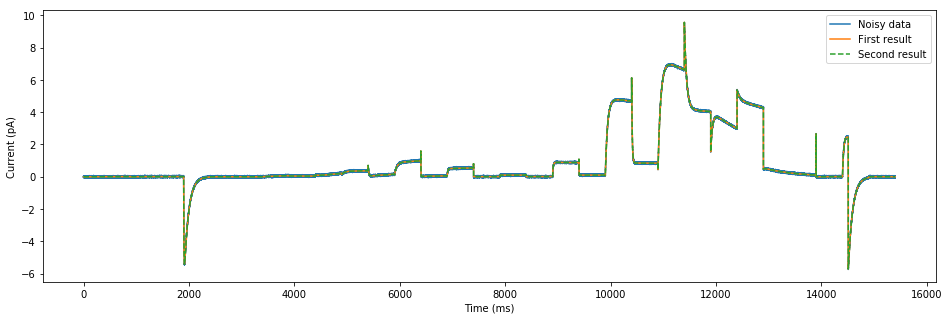

In [12]:
plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(times, values, label='Noisy data')
plt.plot(times, problem.evaluate(x1), label='First result')
plt.plot(times, problem.evaluate(x2), '--', label='Second result')
plt.legend()
plt.show()

While there's a fair amount of stochasticity involved in every re-run, there is a good chance that the results above show the same result obtained by both optimisations, but faster (and with a lower number of total evaluations) when using the log transforms.

## Summary

In this part of the tutorial we have

- Created an object that can transform between model and search space
- Created wrappers around a [pints.ForwardModel](https://pints.readthedocs.io/en/latest/core_classes_and_methods.html#pints.ForwardModel) and [pints.Boundaries](https://pints.readthedocs.io/en/latest/boundaries.html#pints.Boundaries) object.
- Used these to run an optimisation in a transformed parameter space.

Some of the classes we've created here will be useful in further parts of the tutorial, so we've stored them in the file [library.py](library.py).

In the next part of the tutorial, we 